# Proyecto 11

## Preparación y análisis exploratorio de los datos

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
import datetime as dt
import math as mth

In [2]:
# Read DataFrame
df = pd.read_csv('./logs_exp_us.csv', sep='\t',header=0)

# Show DataFrame
print(df.head(3))

                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248


In [3]:
# Show DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


No se tienen valores núlos en las columnas, pero el tipo de dato de algunas no es correcto. Se renombrarán las columnas y se agregarán 2 colunmas.

In [4]:
# Rename columns
df.columns = ['event_name','user_id','event_time','group']

In [5]:
# Change type data
df['event_name'] = df['event_name'].astype('str')
df['event_datetime'] = pd.to_datetime(df['event_time'], unit='s')
df['event_date'] = df['event_datetime'].dt.date

df.head(3)

,event_name,user_id,event_time,group,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25


Se eliminarán filas duplicadas respecto a las columnas "event_name","user_id","event_time", dado que si el valor en éstas es el mismo para dos filas, entonces se asume que esas filas están duplicadas.

In [6]:
# Delete duplicated rows considering a few columns only
df = df.drop_duplicates(subset=["event_name","user_id","event_time"]).reset_index(drop=True)

# Show duplicates considering a few columns only
df.duplicated(subset=["event_name","user_id","event_time"]).sum()

0

## Análisis de los datos

### ¿Cuántos eventos hay en los registros?

In [7]:
# Count unique events
print(len(df['event_name'].unique()))

5


### ¿Cuántos usuarios hay en los registros?

In [8]:
# Count unique users
total_users = len(df['user_id'].unique())
print(total_users)

7551


### ¿Cuál es el promedio de eventos por usuario?

In [9]:
# Count total number of events
total_events = len(df['event_name'])

# Events per user
print(f"{total_events / total_users:.2f}")

32.28


### ¿Qué periodo de tiempo cubren los datos?

In [10]:
# Find minimum and maximum
print(df['event_datetime'].min())
print(df['event_datetime'].max())

2019-07-25 04:43:36
2019-08-07 21:15:17


Los eventos inician desde el dia 2019-07-25 hasta el dia 2019-08-07. A continuación se mostrará un histograma de los eventos.

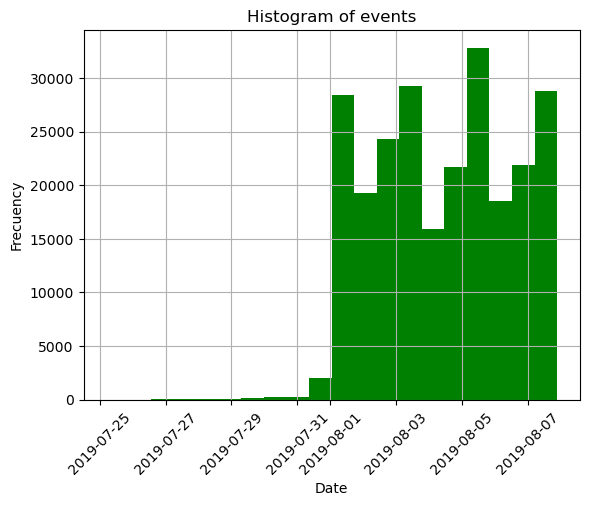

In [11]:
# Histogram of events
df['event_datetime'].hist(bins=20, color='green')
plt.title('Histogram of events')
plt.xlabel('Date')
plt.ylabel('Frecuency')
plt.xticks(rotation=45)
plt.show()

**Nota:** Se puede ver que se tiene información completa de los eventos a partir del dia 2019-08-01, por lo tanto, se descartarán los eventos antes de ese dia.

In [12]:
# Filter by date
df = df[df['event_datetime'] >= pd.to_datetime('2019-08-01')]

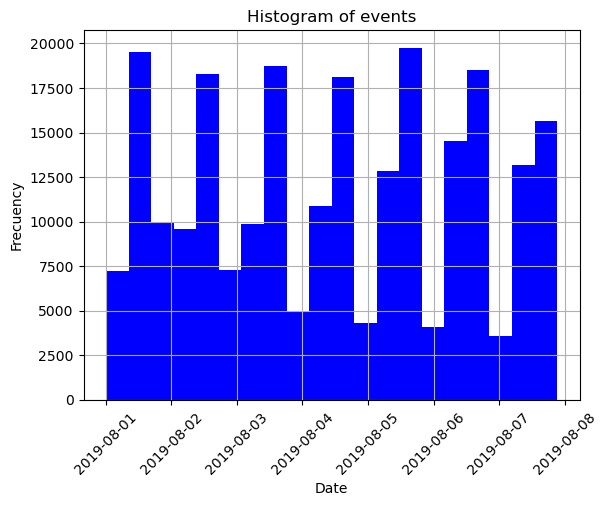

In [13]:
# Histogram of events
df['event_datetime'].hist(bins=20, color='blue')
plt.title('Histogram of events')
plt.xlabel('Date')
plt.ylabel('Frecuency')
plt.xticks(rotation=45)
plt.show()

### ¿Qué periodo representan realmente los datos?

In [14]:
# Find minimum and maximum of date
print(df['event_datetime'].min())
print(df['event_datetime'].max())

2019-08-01 00:07:28
2019-08-07 21:15:17


### ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

No se perdieron muchos datos de eventos, como se puede observar en el histograma verde.

### Asegúrate de tener usuarios de los tres grupos experimentales.

Se tienen usuarios en todos los grupos.

In [15]:
# Obtain groups
groupA1 = df[df['group'] == 246]
groupA2 = df[df['group'] == 247]
groupB = df[df['group'] == 248]

print(f"{len(groupA1)}, {groupA2.shape[0]} y {groupB.shape[0]}.")

79302, 77022 y 84563.


### Observa qué eventos hay en los registros y su frecuencia de suceso.

In [16]:
# Count users per event
events = df.groupby('event_name')['user_id'].count().sort_values(ascending=False)
print(events)

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: user_id, dtype: int64


Tomando en cuenta el numero de usuarios por evento, se puede afirmar que los eventos sucedieron en el siguiente orden:
MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful -> Tutorial.

Para garantizar la secuencialidad de los eventos, se verificarán las fechas, de la siguiente manera.

In [17]:
# Group by 'user_id' and 'event_name' and find minimum time event
users = df.pivot_table(
    index='user_id', columns='event_name', values='event_datetime',
    aggfunc='min', fill_value=pd.to_datetime('1900-01-01')
)
users.head(3)

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
user_id,,,,,
6888746892508752,1900-01-01 00:00:00,2019-08-06 14:06:34,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,1900-01-01
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,1900-01-01


In [18]:
# Conditions to guarantee sequentiality
step1 = users['MainScreenAppear'] != pd.to_datetime('1900-01-01')
step2 = step1 & ( users['OffersScreenAppear']>users['MainScreenAppear'] )
step3 = step2 & ( users['CartScreenAppear']>users['OffersScreenAppear'] )
step4 = step3 & ( users['PaymentScreenSuccessful']>users['CartScreenAppear'] )
step5 = step4 & ( users['Tutorial']>users['PaymentScreenSuccessful'] )

n_step1 = users[step1].shape[0]
n_step2 = users[step2].shape[0]
n_step3 = users[step3].shape[0]
n_step4 = users[step4].shape[0]
n_step5 = users[step5].shape[0]

### Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente.

A continuación se mostrara la proporción de usuarios en cada evento con respecto al evento anterior.

In [19]:
# Total users per event
print(f"MainScreenAppear = 100% ({n_step1})\n"
      f"OffersScreenAppear = {n_step2/n_step1:.2%} ({n_step2})\n"
      f"CartScreenAppear = {n_step3/n_step2:.2%} ({n_step3})\n"
      f"PaymentScreenSuccessful = {n_step4/n_step3:.2%} ({n_step4})\n"
      f"Tutorial = {n_step5/n_step4:.2%} ({n_step5})")

MainScreenAppear = 100% (7419)
OffersScreenAppear = 56.62% (4201)
CartScreenAppear = 42.06% (1767)
PaymentScreenSuccessful = 25.69% (454)
Tutorial = 0.22% (1)


### ¿En qué etapa pierdes más usuarios?

En la segunda etapa (OffersScreenAppear) se pierden más usuarios (56.6%).

### ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?
Sólo el 6.12% de usuarios hacen el pago.

In [20]:
print(f"{n_step4/n_step1:.2%}")

6.12%


## Análisis de las pruebas A/A/B

### ¿Cuántos usuarios hay en cada grupo?

El grupo A1 tiene 79302 usuarios, el grupo A2 tiene 77022 usuarios y el grupo B tiene 84563 usuarios.

In [21]:
# Filter by group
groupA1 = df[df['group'] == 246]
groupA2 = df[df['group'] == 247]
groupB = df[df['group'] == 248]

print(f"{len(groupA1)}, {len(groupA2)} y {len(groupB)}.")

79302, 77022 y 84563.


### Prueba U de Mann-Whitney

Se procedera a realizar las pruebas de Mann-Whitney para determinar si hay una diferencia estadísticamente significativa entre las muestras.

**Nota:** Se usará un umbral de significación (alfa) del 5% para todas las pruebas.

### Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247

In [22]:
# Extract samples
sampleA1 = groupA1.groupby('event_name')['user_id'].count().sort_values(ascending=False)
sampleA2 = groupA2.groupby('event_name')['user_id'].count().sort_values(ascending=False)
sampleB = groupB.groupby('event_name')['user_id'].count().sort_values(ascending=False)

# Show sampleA1
print(sampleA1.head())

event_name
MainScreenAppear           37676
OffersScreenAppear         14767
CartScreenAppear           14690
PaymentScreenSuccessful    11852
Tutorial                     317
Name: user_id, dtype: int64


In [23]:
def mann_whitney_test(sample1, sample2) -> None:
    '''Function to perform the Mann-Whitney U test to determine if
    there are significant differences between two independent groups,
    considering outliers in samples.'''
    # Umbral alpha for the test
    alpha = 0.05
    # Mann-Whitney U test
    result = st.mannwhitneyu(sample1, sample2, True,'two-sided')
    print(f"p-value: {result.pvalue:.2%}")
    if result.pvalue < alpha:
        print("H0 is rejected: Significant differences between the two groups")
    else:
        print("H0 cannot be rejected: No significant differences between the two groups")

In [24]:
mann_whitney_test(sampleA1, sampleA2)

p-value: 100.00%
H0 cannot be rejected: No significant differences between the two groups


No hay diferencias significativas entre los grupos 246 y 247.

In [25]:
mann_whitney_test(sampleA1, sampleB)

p-value: 54.76%
H0 cannot be rejected: No significant differences between the two groups


No hay diferencias significativas entre los grupos 246 y 248.

In [26]:
mann_whitney_test(sampleA2, sampleB)

p-value: 60.04%
H0 cannot be rejected: No significant differences between the two groups


No hay diferencias significativas entre los grupos 247 y 248.

**Conclusión:** No hay diferencia estadísticamente significativa entre las muestras, por lo tanto, las prubas A/A se realizaron exitosamente y la estrategia de "cambiar las fuentes de toda la aplicación" no funcionó como se esperaba.

#### Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción. Encuentra su proporción.

### Prueba de proporción

Se procedera a realizar las pruebas de proporción para probar la hipótesis de que las proporciones son iguales, es decir, si hay una diferencia entre las tasas de conversion de las muestras. Estas pruebas se harán para el evento 2 (OffersScreenAppear) y 4 (PaymentScreenSuccessful), la prueba para los demás eventos es similar.

In [27]:
def proportion_test(sample1, sample2, event: int=1) -> None:
    '''Function to perform the proportion test to determine if
    there is significant difference between the proportions'''
    # Umbral alpha for the test
    alpha = 0.05
    
    successes = np.array([sample1[event], sample2[event]])
    trials = np.array([sample1[0], sample2[0]])
    
    # Success proportion for group 1
    p1 = successes[0]/trials[0]
    
    # Success proportion for group 2
    p2 = successes[1]/trials[1]
    
    # Success proportion of combined Dataset:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    # Proportion difference
    difference = p1 - p2
    
    # Calculate the statistic in standard deviations of the standard normal distribution
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    # Set the standard normal distribution (mean 0, standard deviation 1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print(f"p-value: {p_value:.2%}")
    if (p_value < alpha):
        print("H0 is rejected: Significant difference between the proportions")
    else:
        print("H0 cannot be rejected: No reason to think that the proportions are different")

#### Para el evento 2 (OffersScreenAppear):

In [28]:
proportion_test(sampleA1, sampleA2, 1)

p-value: 30.16%
H0 cannot be rejected: No reason to think that the proportions are different


/tmp/ipykernel_89564/1633104788.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  successes = np.array([sample1[event], sample2[event]])
/tmp/ipykernel_89564/1633104788.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trials = np.array([sample1[0], sample2[0]])


In [29]:
proportion_test(sampleA1, sampleB, 1)

p-value: 0.06%
H0 is rejected: Significant difference between the proportions


/tmp/ipykernel_89564/1633104788.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  successes = np.array([sample1[event], sample2[event]])
/tmp/ipykernel_89564/1633104788.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trials = np.array([sample1[0], sample2[0]])


In [30]:
proportion_test(sampleA2, sampleB, 1)

p-value: 0.00%
H0 is rejected: Significant difference between the proportions


/tmp/ipykernel_89564/1633104788.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  successes = np.array([sample1[event], sample2[event]])
/tmp/ipykernel_89564/1633104788.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trials = np.array([sample1[0], sample2[0]])


**Conclusión:** Parece que si hay diferencia en las proporciones de las muestras A1 y A2 con B.

#### Para el evento 4 (PaymentScreenSuccessful):

In [31]:
proportion_test(sampleA1, sampleA2, 3)

p-value: 0.00%
H0 is rejected: Significant difference between the proportions


/tmp/ipykernel_89564/1633104788.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  successes = np.array([sample1[event], sample2[event]])
/tmp/ipykernel_89564/1633104788.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trials = np.array([sample1[0], sample2[0]])


In [32]:
proportion_test(sampleA1, sampleB, 3)

p-value: 0.00%
H0 is rejected: Significant difference between the proportions


/tmp/ipykernel_89564/1633104788.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  successes = np.array([sample1[event], sample2[event]])
/tmp/ipykernel_89564/1633104788.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trials = np.array([sample1[0], sample2[0]])


In [33]:
proportion_test(sampleA2, sampleB, 3)

p-value: 0.00%
H0 is rejected: Significant difference between the proportions


/tmp/ipykernel_89564/1633104788.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  successes = np.array([sample1[event], sample2[event]])
/tmp/ipykernel_89564/1633104788.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trials = np.array([sample1[0], sample2[0]])


**Conclusión:** Parece que si hay diferencia en las proporciones de las muestras A1 y A2 con B.

### ¿Qué conclusiones puedes sacar del experimento?

Con base en las pruebas de proporcion para el evento 4, no se puede concluir que existe diferencia significativa entre las proporciones de las muestras, dado que los resultados indican que hay diferencia significativa entre las proporciones para todos los grupos (A1 con A2, A1 con B, A2 con B).

Por otro lado, con base en las pruebas U de Mann-Whitney, se concluye que no existe diferencia estadísticamente significativa entre las muestras (A1 con A2, A1 con B, A2 con B), pero en estas pruebas se usó todos los datos de las muestras.

Por lo tanto, se concluye que no hay diferencia estadísticamente significativa entre las muestras, por lo tanto, las prubas A/A se realizaron exitosamente y la estrategia de "cambiar las fuentes de toda la aplicación" no funcionó como se esperaba.